In [1]:
import copy

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from Strategy import *

sns.set()

In [1]:
txt_file = open('ticker_list.txt', 'r')
sp500_list = [line.rstrip('\n') for line in txt_file]

In [2]:
len(sp500_list)

1800

In [3]:
len(set(sp500_list))

1708

In [4]:
tick_list = list(set(sp500_list))

In [5]:
with open('broader_ticker.txt', 'w') as file:
    for ticker in tick_list:
        file.write("%s\n" % ticker)

In [6]:
txt_file = open('broader_ticker.txt', 'r')
br_list = [line.rstrip('\n') for line in txt_file]

In [7]:
len(br_list), len(set(br_list))

(1708, 1708)

In [2]:
def data_preprocess(dta):
    dta['Date'] = pd.to_datetime(dta['Date'], format='%Y-%m-%d')
    dta = dta.set_index(dta['Date'])
    dta.drop(['Date'], axis=1, inplace=True)
    dta.dropna(how='all', inplace=True)
    for tick in dta.columns:
        tick_series = dta[tick]
        start_pos = tick_series.first_valid_index()
        valid_series = tick_series.loc[start_pos:]
        if valid_series.isna().sum() > 0:
            dta.drop(tick, axis=1, inplace=True)

    for tick in dta.columns:
        dta[tick] = dta[tick].mask(dta[tick] == 0).ffill(downcast='infer')

    return dta[dta.index >= dta['SPY'].first_valid_index()]

In [3]:
df = pd.read_csv("SP500.csv")
# df.drop(['Unnamed: 0'], axis=1, inplace=True)
print(df.shape)
df = data_preprocess(df)
print(df.shape)
ticker = list(df.columns)
ticker.remove('SPY')

(10187, 576)
(6880, 508)


In [4]:
class Agent:

    def __init__(self, data, trading_strategies, rebalancing_strategies, cycle, max_holding, gamma):

        self.portfolio = {'cash': INITIAL_BALANCE}
        self.data = data
        self.trading_strategies = trading_strategies
        self.rebalancing_strategies = rebalancing_strategies
        self.cycle = cycle
        self.max_holding = max_holding
        self.tran_cost = float(0)

        # parameter for risk preference (proportion that invest into SPY)
        self.gamma = gamma

    def get_equity(self, time):
        portfolio = copy.deepcopy(self.portfolio)
        cash = portfolio['cash']
        ttl_equity = cash

        del portfolio['cash']
        if len(portfolio.values()) != 0:
            shares = np.array(list(portfolio.values()))
            prices = np.array(self.data[list(portfolio.keys())].iloc[time])
            ttl_equity += shares @ prices
        return ttl_equity

    def PitchStock(self, trad_strat, rebal_strat, time):
        cycle = self.cycle
        data = self.data
        max_holding = self.max_holding
        equity = self.get_equity(time)
        ranking = {}
        for i in ticker:
            metric = trad_strat(data[i], cycle, time)
            if metric is not None and not math.isnan(metric):
                ranking[i] = metric
        result = sorted(ranking, key=ranking.get)[:max_holding]

        weight = np.array(rebal_strat(data, result, time, cycle))
        safe_weight = self.gamma
        target_weight = np.append(weight * (1 - safe_weight), safe_weight)
        dollar_weight = (target_weight * equity).astype(int)
        result.append('SPY')

        target_portfolio = {}
        for w, stock in zip(dollar_weight, result):
            price = data[stock].iloc[time]
            shares = w // price
            target_portfolio[stock] = shares
            equity -= shares * price

        target_portfolio['cash'] = equity

        return target_portfolio

    def Trade(self, target_portfolio, time):
        cost = float(0)
        data = self.data
        portfolio = self.portfolio

        for i in portfolio:
            if i not in target_portfolio and i != 'cash':
                cost += portfolio[i] * data[i].iloc[time] * TRANS_COST
            elif i in target_portfolio and i != 'cash':
                diff = abs(portfolio[i] - target_portfolio[i])
                cost += diff * data[i].iloc[time] * TRANS_COST

        for j in target_portfolio:
            if j not in portfolio:
                cost += target_portfolio[j] * data[j].iloc[time] * TRANS_COST

        self.tran_cost += cost
        self.portfolio = target_portfolio

    def Backtest_Single(self, trad_strat, rebal_strat):
        cycle = self.cycle
        data = self.data
        print("Trading strategy: %s \n" % trad_strat.__name__)
        print("Rebalancing strategy: %s \n" % rebal_strat.__name__)
        T = len(data) // cycle
        print("We are rebalancing for %s number of times." % T)

        portfolio_path = []
        _ = 0

        for t in range(1, len(data)):
            # non-trading period
            equity = self.get_equity(t)
            portfolio_path.append(equity)
            # trading period
            if t % cycle == 0:
                target_portfolio = self.PitchStock(trad_strat, rebal_strat, t)
                self.Trade(target_portfolio, t)
                _ += 1
                print("Rebalancing for %s time!" % _)
        return portfolio_path

    def reset(self):
        self.portfolio = {'cash': INITIAL_BALANCE}
        self.tran_cost = float(0)

    def Backtest_All(self):
        trading_strategies = self.trading_strategies
        rebalancing_strategies = self.rebalancing_strategies
        print("There are %s trading strategies and %s rebalancing strategies we are testing." % (
            len(trading_strategies), len(rebalancing_strategies)))
        print("Trading Strategies: ")
        for i in trading_strategies:
            print("     %s \n" % i.__name__)
        print("Rebalacing Strategies: ")
        for i in rebalancing_strategies:
            print("     %s \n" % i.__name__)

        portfolio_re = pd.DataFrame(index=[x.__name__ for x in rebalancing_strategies],
                                    columns=[x.__name__ for x in trading_strategies])
        portfolio_vol = pd.DataFrame(index=[x.__name__ for x in rebalancing_strategies],
                                     columns=[x.__name__ for x in trading_strategies])
        portfolio_sharpe = pd.DataFrame(index=[x.__name__ for x in rebalancing_strategies],
                                        columns=[x.__name__ for x in trading_strategies])


        for col, trad_strat in enumerate(trading_strategies):
            for row, rebal_strat in enumerate(rebalancing_strategies):
                path = self.Backtest_Single(trad_strat, rebal_strat)
                path = np.array(path)

                ttl_ret = np.maximum((path[-1] - self.tran_cost) / path[0], 0)
                annual_ret = np.power(np.power(ttl_ret, 1/len(path)), 252) - 1
                annual_vol = (np.diff(path) / path[1:]).std() * np.power(252, 1/2)
                annual_sharpe = annual_ret / annual_vol

                portfolio_re.iloc[row][col] = annual_ret
                portfolio_vol.iloc[row][col] = annual_vol
                portfolio_sharpe.iloc[row][col] = annual_sharpe

                self.reset()
                print('\n')

        return portfolio_re, portfolio_vol, portfolio_sharpe

In [7]:
INITIAL_BALANCE = 50000
TRANS_COST = 0.001
CYCLE = 10
MAX_HOLDING = 20

wsw = Agent(df, trading_strategies, rebalancing_strategies, CYCLE, MAX_HOLDING, 0.4)

In [12]:
len(test_path), df.shape

(6879, (6880, 508))

In [13]:
portfolio = pd.DataFrame(test_path, index=df.index[1:len(test_path)+1], columns=['VAL'])
portfolio['RET'] = portfolio['VAL'].pct_change()
portfolio.dropna(inplace=True)

In [14]:
ff = pd.read_csv('ff5.csv')
mom = pd.read_csv('mom.csv')

ff['Date'] = pd.to_datetime(ff['Unnamed: 0'], format='%Y%m%d')
ff = ff.set_index(ff['Date'])
ff.drop(['Date', 'Unnamed: 0'], axis=1, inplace=True)

mom['Date'] = pd.to_datetime(mom['Unnamed: 0'], format='%Y%m%d')
mom = mom.set_index(mom['Date'])
mom.drop(['Date', 'Unnamed: 0'], axis=1, inplace=True)

ff = ff.join(mom, how='inner')

In [15]:
portfolio.columns

Index(['VAL', 'RET'], dtype='object')

In [16]:
portfolio = portfolio.join(ff, how='inner')
portfolio['RET'] = portfolio['RET'] * 100

In [17]:
import statsmodels.api as sm

In [18]:
X = sm.add_constant(portfolio[['Mkt-RF', 'SMB', 'HML', 'Mom   ']])
y = portfolio['RET']

lm = sm.OLS(y, X).fit()

In [19]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RET   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     127.2
Date:                Wed, 03 Jun 2020   Prob (F-statistic):          6.33e-105
Time:                        22:49:37   Log-Likelihood:                -19044.
No. Observations:                6861   AIC:                         3.810e+04
Df Residuals:                    6856   BIC:                         3.813e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2009      0.047      4.278      0.000       0.109       0.293
Mkt-RF         0.8639      0.041     21.069      0.000       0.784       0.944
SMB            0.1700      0.080      2.132      0.033       0.014       0.326
HML            0.0243      0.080      0.304      0.761      -0.132       0.181
Mom           -0.1351      0.058     -2.335      0.020      -0.248      -0.022
==============================================================================
Omnibus:                    15259.821   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        172114556.455
Skew:                          20.249   Prob(JB):                         0.00
Kurtosis:                     777.869   Cond. No.                         2.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
test_path = wsw.Backtest_Single(Price_High_Low, RiskParity)

Trading strategy: Price_High_Low 

Rebalancing strategy: RiskParity 

We are rebalancing for 688 number of times.
Rebalancing for 1 time!
Rebalancing for 2 time!
Rebalancing for 3 time!
Rebalancing for 4 time!
Rebalancing for 5 time!
Rebalancing for 6 time!
Rebalancing for 7 time!
Rebalancing for 8 time!
Rebalancing for 9 time!
Rebalancing for 10 time!
Rebalancing for 11 time!
Rebalancing for 12 time!
Rebalancing for 13 time!
Rebalancing for 14 time!
Rebalancing for 15 time!
Rebalancing for 16 time!
Rebalancing for 17 time!
Rebalancing for 18 time!
Rebalancing for 19 time!
Rebalancing for 20 time!
Rebalancing for 21 time!
Rebalancing for 22 time!
Rebalancing for 23 time!
Rebalancing for 24 time!
Rebalancing for 25 time!
Rebalancing for 26 time!
Rebalancing for 27 time!
Rebalancing for 28 time!
Rebalancing for 29 time!
Rebalancing for 30 time!
Rebalancing for 31 time!
Rebalancing for 32 time!
Rebalancing for 33 time!
Rebalancing for 34 time!
Rebalancing for 35 time!
Rebalancing for 36 t

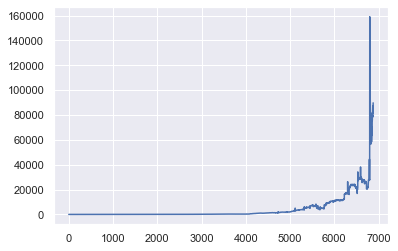

In [9]:
path = np.array(test_path)
arr_ret = path / path[0]
plt.plot(arr_ret)

In [21]:
np.argmax(arr_ret), np.max(arr_ret)

(6801, 159064.31960995198)

In [10]:
ttl_ret = (path[-1] - wsw.tran_cost) / path[0]
annual_ret = np.power(np.power(ttl_ret, 1/len(path)), 252)

In [11]:
annual_ret

1.5165053787612253

In [102]:
test_path_2 = wsw.Backtest_Single(Price_High_Low, EqualWeight)

Trading strategy: Price_High_Low 

Rebalancing strategy: EqualWeight 

We are rebalancing for 688 number of times.
Rebalancing for 1 time!
Rebalancing for 2 time!
Rebalancing for 3 time!
Rebalancing for 4 time!
Rebalancing for 5 time!
Rebalancing for 6 time!
Rebalancing for 7 time!
Rebalancing for 8 time!
Rebalancing for 9 time!
Rebalancing for 10 time!
Rebalancing for 11 time!
Rebalancing for 12 time!
Rebalancing for 13 time!
Rebalancing for 14 time!
Rebalancing for 15 time!
Rebalancing for 16 time!
Rebalancing for 17 time!
Rebalancing for 18 time!
Rebalancing for 19 time!
Rebalancing for 20 time!
Rebalancing for 21 time!
Rebalancing for 22 time!
Rebalancing for 23 time!
Rebalancing for 24 time!
Rebalancing for 25 time!
Rebalancing for 26 time!
Rebalancing for 27 time!
Rebalancing for 28 time!
Rebalancing for 29 time!
Rebalancing for 30 time!
Rebalancing for 31 time!
Rebalancing for 32 time!
Rebalancing for 33 time!
Rebalancing for 34 time!
Rebalancing for 35 time!
Rebalancing for 36 

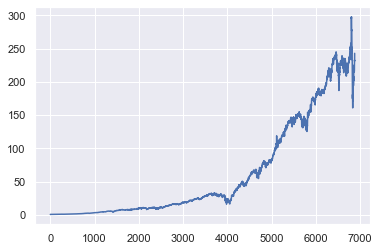

In [103]:
arr = np.array(test_path_2)
arr_ret = arr / arr[0]
plt.plot(arr_ret)

In [104]:
np.power((np.power(arr_ret[-1], 1/len(test_path))), 252)

1.2228630222739107

In [7]:
trading_strategies

[<function Strategy.MovingAverage(df, cycle, time)>,
 <function Strategy.PriceReverse(df, cycle, time)>,
 <function Strategy.PriceMomentum(df, cycle, time)>,
 <function Strategy.MomentumReturn(df, cycle, time)>,
 <function Strategy.MeanCutOff(df, cycle, time)>,
 <function Strategy.Price_High_Low(df, cycle, time)>,
 <function Strategy.Vol_Coefficient(df, cycle, time)>,
 <function Strategy.AnnVol(df, cycle, time)>,
 <function Strategy.MACD(df, cycle, time)>,
 <function Strategy.BoolingerBands(df, cycle, time)>]

In [8]:
rebalancing_strategies

[<function Strategy.MinVariance(data, ranking, time, cycle)>,
 <function Strategy.EqualWeight(data, ranking, time, cycle)>,
 <function Strategy.RiskParity(data, ranking, time, cycle)>]

In [14]:
def data_preprocess(dta):
    dta['Date'] = pd.to_datetime(dta['Date'], format='%Y-%m-%d')
    dta = dta.set_index(dta['Date'])
    dta.drop(['Date'], axis=1, inplace=True)
    dta.dropna(how='all', inplace=True)
    for tick in dta.columns:
        tick_series = dta[tick]
        start_pos = tick_series.first_valid_index()
        valid_series = tick_series.loc[start_pos:]
        if valid_series.isna().sum() > 0:
            dta.drop(tick, axis=1, inplace=True)

    return dta

In [15]:
dta = data_preprocess(dta)

In [42]:
df['SPY'].first_valid_index()

Timestamp('1993-01-29 00:00:00')

In [44]:
from datetime import datetime

In [48]:
df[df.index >= df['SPY'].first_valid_index()]

,NKE,DDS,IPG,LLY,MTG,NAVI,WY,CI,EBAY,NCR,...,MANT,VAL,EMR,WU,TEX,XOM,TPR,TER,BLK,SPY
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,0.14,40.78,6.37,4.05,11.29,NaN,17.35,3.42,NaN,NaN,...,NaN,7.9348,3.64,NaN,4.37,3.48,NaN,3.42,NaN,26.30
1993-02-01,0.14,40.26,6.42,4.01,11.56,NaN,17.56,3.55,NaN,NaN,...,NaN,7.5570,3.64,NaN,4.55,3.50,NaN,3.27,NaN,26.49
1993-02-02,0.14,40.68,6.19,3.96,11.67,NaN,17.62,3.54,NaN,NaN,...,NaN,7.9348,3.62,NaN,4.66,3.54,NaN,3.24,NaN,26.54
1993-02-03,0.14,42.45,6.47,4.04,11.81,NaN,17.56,3.66,NaN,NaN,...,NaN,7.9348,3.69,NaN,4.61,3.56,NaN,3.45,NaN,26.82
1993-02-04,0.15,42.45,6.47,4.03,12.03,NaN,17.83,3.73,NaN,NaN,...,NaN,7.5570,3.78,NaN,4.78,3.70,NaN,3.51,NaN,26.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-19,91.51,25.28,16.05,156.70,7.24,6.87,18.52,191.78,42.40,17.82,...,70.80,0.3200,55.70,18.76,14.15,43.94,12.86,61.12,501.20,291.97
2020-05-20,92.95,26.28,16.67,153.13,7.98,7.10,19.48,188.27,42.71,18.68,...,72.16,0.3300,56.81,19.13,14.86,45.37,13.26,63.53,508.74,296.93
2020-05-21,94.26,27.61,16.33,152.28,7.91,7.18,19.45,188.68,42.47,18.16,...,71.11,0.3300,56.25,18.89,14.36,44.56,14.24,61.74,508.51,294.88


In [9]:
for tick in dta.columns:
    tick_series = dta[tick]
    start_pos = tick_series.first_valid_index()
    valid_series = tick_series.loc[start_pos:]
    print((valid_series == 0).sum(), valid_series.isna().sum())

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


In [8]:
for tick in dta.columns:
    dta[tick] = dta[tick].mask(dta[tick] == 0).ffill(downcast='infer')

In [10]:
dta.shape

(10187, 508)

In [27]:
for tick in dta.columns:
    tick_series = dta[tick]
    start_pos = tick_series.first_valid_index()
    valid_series = tick_series.loc[start_pos:]
    print((valid_series == 0).sum(), valid_series.isna().sum())

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
179 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
220 0
838 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
128 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1660 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0

In [16]:
dta.shape

(10187, 508)

In [7]:
dta.SPY.first_valid_index()

Timestamp('1993-01-29 00:00:00')

In [18]:
(dta.SPY.loc[dta.SPY.first_valid_index():]) == 0)

Date
1993-01-29    False
1993-02-01    False
1993-02-02    False
1993-02-03    False
1993-02-04    False
              ...  
2020-05-19    False
2020-05-20    False
2020-05-21    False
2020-05-22    False
2020-05-26    False
Name: SPY, Length: 6880, dtype: bool

In [9]:
dta.isna().sum(axis=0)

NKE     256
DDS      76
IPG      76
LLY      24
MTG    2956
       ... 
XOM      24
TPR    5273
TER      24
BLK    5016
SPY    3331
Length: 575, dtype: int64

In [197]:
dta = dta[dta.index >= datetime(1993, 1, 29)]
dta.drop([datetime(1995, 9, 4), datetime(2020, 5, 15), datetime(1995, 11, 23)], axis=0, inplace=True)

In [202]:
dta.drop(['PA'], axis=1, inplace=True)

In [203]:
ticker_universe = list(set(dta.columns))

In [204]:
ticker_universe.remove('SPY')

In [205]:
len(ticker_universe)

573

In [26]:
sub_dta = dta.iloc[20:40]

In [48]:
next_dta = dta.iloc[40:60]

In [45]:
ranking = sub_dta.apply(lambda x: (x[-1] - x[0])/x[0])

select_tic = ranking.dropna().sort_values()[:10].index.to_list()

In [50]:
select_tic

['IAC', 'WDC', 'BSX', 'NAV', 'EPHC', 'GILD', 'BIIB', 'MNST', 'MRK', 'LLY']

In [92]:
(np.array(next_dta_tic) @ weight)[-1]

49257.619999999995

In [108]:
test = np.array([])

test = np.append(test, np.array(next_dta_tic) @ weight)

test

array([187889.3477, 156855.5221, 172021.1975, 173811.567 , 159781.487 ,
       151719.097 , 113299.297 , 113913.0974, 105514.744 , 102994.027 ,
       187843.437 , 129839.087 , 130301.347 , 110537.607 , 124086.647 ,
       123024.232 , 118299.749 , 129731.934 , 124741.474 , 127846.9895])

In [109]:
total_eq // 10

C:\Users\Andyy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in double_scalars



nan

In [110]:
5000 / np.array(next_dta_tic.iloc[0])

array([2.17391304e+04, 8.92857143e+01, 5.36480687e+02, 1.63934426e+03,
       1.00000000e+07, 1.35501355e+03, 1.08932462e+03, 3.54609929e+03,
       1.49253731e+03, 2.24346031e+03])

In [111]:
weight = (5000 / np.array(next_dta_tic.iloc[0])).round()

In [112]:
weight

array([2.1739e+04, 8.9000e+01, 5.3600e+02, 1.6390e+03, 1.0000e+07,
       1.3550e+03, 1.0890e+03, 3.5460e+03, 1.4930e+03, 2.2430e+03])

In [113]:
next_dta_tic = next_dta[select_tic]

In [114]:
sub_dta

,NKE,DDS,IPG,LLY,MTG,NAVI,WY,CI,PLU,WTR,...,VAL,EMR,WU,AVP,TEX,XOM,TPR,TER,BLK,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-30,97.92,67.26,22.93,141.27,13.72,14.69,29.71,196.95,NaN,52.11,...,5.20,72.63,27.32,NaN,25.75,62.66,26.27,68.75,535.63,325.76
2020-01-31,96.03,60.49,22.43,138.27,13.62,14.17,28.60,192.34,NaN,51.71,...,5.11,70.47,26.63,NaN,25.21,60.08,25.41,65.89,523.38,319.85
2020-02-03,99.00,60.28,22.51,139.62,13.93,13.81,27.88,191.73,NaN,53.49,...,5.12,71.42,26.81,NaN,25.33,58.73,25.67,67.70,526.09,322.23
2020-02-04,101.10,60.37,22.60,142.03,14.09,13.62,27.84,196.82,NaN,52.76,...,5.27,72.05,27.18,NaN,25.76,58.00,26.82,70.37,531.21,327.14
2020-02-05,100.26,62.78,23.24,145.90,14.34,13.87,28.57,206.44,NaN,53.10,...,5.62,74.78,27.64,NaN,26.97,60.67,28.00,71.18,539.39,330.91
2020-02-06,99.99,64.05,22.94,145.85,14.19,13.90,28.31,211.82,NaN,52.97,...,5.32,74.03,27.69,NaN,26.65,59.84,28.60,71.27,550.49,332.03
2020-02-07,99.16,64.44,22.75,144.97,14.08,13.81,28.24,208.88,NaN,52.99,...,5.23,72.57,27.37,NaN,25.42,59.45,27.58,69.35,551.56,330.26
2020-02-10,99.74,64.75,22.89,144.08,14.05,13.88,28.31,210.28,NaN,53.49,...,4.76,72.20,28.01,NaN,25.52,58.82,28.11,70.45,556.87,332.72
2020-02-11,99.74,66.46,22.98,142.83,14.07,14.29,28.55,215.14,NaN,53.04,...,5.07,72.63,27.95,NaN,26.10,59.38,28.18,72.29,566.14,333.30


In [208]:
cycle = 20
N_portfolio = 10
total_eq = 5e4

portfolio_hist = np.array([total_eq])

T = dta.shape[0] // cycle
T

344

In [209]:
for t in range(102, T-1):
    sub_dta = dta.iloc[(t-1)*cycle : t*cycle]
    ranking = sub_dta.apply(lambda x: (x[-1] - x[0])/x[0])
    select_tic = ranking.dropna().sort_values()[:10].index.to_list()
    print(select_tic)
    next_dta = dta.iloc[t*cycle : (t+1)*cycle][select_tic]
    
    eq = total_eq // N_portfolio
    weight = (eq / np.array(next_dta.iloc[0])).round()
    print(weight)
    temp_hist = np.array(next_dta) @ weight
    print(list(temp_hist))
    total_eq = temp_hist[-1]
    
    # portfolio_hist = np.append(portfolio_hist, temp_hist)
    
    print("{}/{}".format(t, T-1))

['ACR', 'CD', 'JNPR', 'ALXN', 'NTAP', 'GLW', 'ORCL', 'ADBE', 'VRSN', 'CSCO']
[25000.   222.    71.   543.   147.   165.   256.   271.   102.   229.]
[49993.100000000006, 52595.03, 53574.38999999999, 49746.43, 47764.829999999994, 46478.44, 45118.82, 45923.030000000006, 47436.67, 43109.8, 41472.950000000004, 42889.10999999999, 40215.0, 40493.340000000004, 41415.88, 40528.189999999995, 39061.93, 36801.41, 34414.159999999996, 36767.24999999999]
102/343
['AKAM', 'FFIV', 'ALXN', 'NTAP', 'VRTX', 'CTXS', 'AABA', 'CMT', 'ETFC', 'GLW']
[ 327. 1250.  735.  203.  106.  272. 1759. 4223.   56.  199.]
[36782.0592, 35329.2999, 33751.6499, 37356.7799, 35684.289899999996, 34482.4899, 36677.4799, 37901.12989999999, 37181.4852, 37619.205200000004, 34746.845199999996, 34058.7699, 35374.5599, 32786.859899999996, 29006.6083, 28439.946699999997, 32666.9414, 32761.1446, 33765.8446, 36782.686100000006]
103/343
['ISRG', 'EPHC', 'DXC', 'PCG', 'JNPR', 'HUM', 'VIAV', 'SANM', 'INTU', 'NTAP']
[1649. 1042.  394.  705.

C:\Users\Andyy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in double_scalars



[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
122/343
['AMT', 'AES', 'FLS', 'SANM', 'URI', 'AMD', 'NFLX', 'MLSS', 'CLF', 'LH']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
123/343
['THC', 'CI', 'TEX', 'HRB', 'IPG', 'GT', 'UHS', 'HES', 'DRI', 'UW']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
124/343
['SPC', 'LOM', 'MANT', 'BIIB', 'PDCO', 'CU', 'WMB', 'SRCL', 'TEN', 'PEAK']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
125/343
['GME', 'MU', 'UW', 'ACR', 'HD', 'EA', 'URBN', 'ISRG', 'WAT', 'MLSS']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
195/343
['PP', 'ODP', 'PPE', 'UT', 'CNX', 'SSP', 'AKAM', 'CBRE', 'COG', 'CGCO']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
196/343
['KNE', 'PPE', 'USAS', 'AIG', 'CGCO', 'BKNG', 'IIN', 'CHL', 'CRM', 'UW']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
197/343
['AIG', 'GNW', 'LOM', 'AKS', 'CDG', 'MS', 'CLF', 'SANM', 'CIEN', 'JBL']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
198/343
['TEN', 'BC', 'CAR', 'DAN', 'SITC', 'DDR', 'ODP', 'PIR', 'NOB', 'MTG']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
268/343
['PPE', 'ACR', 'FTN', 'NHLI', 'CHV', 'CGCO', 'MEE', 'PLU', 'STCO', 'VIAV']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
269/343
['PP', 'STCO', 'CGCO', 'CDG', 'LOM', 'SAI', 'FTN', 'MEE', 'TERX', 'SPC']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
270/343
['PPE', 'SAI', 'NHLI', 'CDG', 'CGCO', 'MBI', 'MXM', 'TERX', 'CDIC', 'AMBC']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
271/343
['PPE', 'FTN', 'STCO', 'S', 'NHLI', 'CZR', 'GNW', 'MXM', 'KODK', 'IVC']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

C:\Users\Andyy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in double_scalars



['NOB', 'SNS', 'TERX', 'REI', 'DNR', 'WPX', 'PLU', 'RIG', 'NBR', 'FOH']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
276/343
['NOB', 'PP', 'X', 'URI', 'SWN', 'NB', 'AVP', 'CZR', 'QEP', 'CNX']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
277/343


C:\Users\Andyy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

divide by zero encountered in double_scalars



['NOB', 'PPE', 'ACR', 'TERX', 'MEE', 'HMT', 'SPC', 'SRL', 'PP', 'LOM']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
278/343
['NOB', 'SPC', 'ACR', 'PIR', 'SCE', 'CHK', 'VAL', 'PE', 'MXM', 'ANF']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
279/343
['TERX', 'SCE', 'PP', 'MEE', 'CLF', 'ACAD', 'CMX', 'FOH', 'LOM', 'FTN']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
280/343
['SPC', 'ACR', 'COFI', 'AHC', 'CMX', 'MAY', 'STA', 'CZR', 'MANT', 'AMD']
[nan nan nan nan nan nan nan nan nan nan]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
281/343
['SPC', 'PP', 'NHLI', 'LMC', 'CD', 'KNE', 'FTR', 'PPE', 'CZR', 'SCE']
[nan nan nan nan nan nan nan nan nan nan

In [207]:
t = 103

sub_dta = dta.iloc[(t-1)*cycle : t*cycle]
ranking = sub_dta.apply(lambda x: (x[-1] - x[0])/x[0])
select_tic = ranking.dropna().sort_values()[:10].index.to_list()
print(select_tic)
next_dta = dta.iloc[t*cycle : (t+1)*cycle][select_tic]

eq = total_eq // N_portfolio
weight = (eq / np.array(next_dta.iloc[0])).round()
print(weight)
temp_hist = np.array(next_dta) @ weight
print(list(temp_hist))
total_eq = temp_hist[-1]

['AKAM', 'FFIV', 'ALXN', 'NTAP', 'VRTX', 'CTXS', 'AABA', 'CMT', 'ETFC', 'GLW']
[ 444. 1701. 1000.  276.  144.  370. 2392. 5744.   76.  271.]
[50010.717599999996, 48036.247200000005, 45891.877199999995, 50793.8372, 48520.5972, 46887.4972, 49873.4872, 51537.5772, 50556.88560000001, 51152.44560000001, 47246.0056, 46309.9172, 48098.36719999999, 44581.2972, 39441.4324, 38670.6076, 44417.279200000004, 44545.9288, 45912.1788, 50012.4008]


In [185]:
sub_dta = dta.iloc[(t-1)*cycle : t*cycle]
ranking = sub_dta.apply(lambda x: (x[-1] - x[0])/x[0])

In [188]:
select_tic

['AKAM', 'PA', 'FFIV', 'ALXN', 'NTAP', 'VRTX', 'CTXS', 'AABA', 'CMT', 'ETFC']

In [189]:
next_dta = dta.iloc[t*cycle : (t+1)*cycle][select_tic]

In [190]:
next_dta

,AKAM,PA,FFIV,ALXN,NTAP,VRTX,CTXS,AABA,CMT,ETFC
Date,,,,,,,,,,
2001-03-14,11.25,NaN,2.94,5.00,18.12,34.62,13.51,2.09,0.8704,66.16
2001-03-15,9.31,0.01,2.78,5.12,16.03,33.75,14.04,2.04,0.7913,67.94
2001-03-16,8.22,0.01,2.52,5.02,16.19,31.62,14.09,1.85,0.7913,64.38
2001-03-19,9.47,0.01,3.25,5.69,17.48,34.31,14.82,2.04,0.7913,71.58
2001-03-20,8.88,0.01,3.38,4.97,15.93,32.06,15.46,1.90,0.7913,66.25
2001-03-21,8.34,0.01,3.24,5.05,16.46,29.94,13.80,1.87,0.7913,60.83
2001-03-22,8.69,0.01,3.36,6.19,19.23,29.19,15.26,2.03,0.7913,58.43
2001-03-23,8.53,0.01,3.72,6.80,18.06,31.12,16.82,1.97,0.7913,61.81
2001-03-26,9.41,0.01,3.28,6.34,17.00,34.88,17.07,1.93,0.6924,63.23
